# AIPI 590 - XAI | Assignment #8

## Description

In this assignment, you will work with a dataset from a telecommunications company (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code). The company is interested in understanding the factors that contribute to customer churn (customers leaving the company for a competitor) and developing interpretable models to predict which customers are at risk of churning.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/suneel-nadipalli/xai-assignments-duke-fall24/blob/main/Assignment%208/XAI_Assignment_8_XAI_in_LLMs.ipynb)

## Suneel Nadipalli

## Importing Libraries

In [1]:
!pip install transformers torch shap --quiet

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, AutoModelForCausalLM, AutoTokenizer

import shap

import matplotlib.pyplot as plt

## Helper Functions

In [3]:
def capture_activations(tokens, model):
    """
    Captures and returns neuron activations for each layer in a given model.

    Parameters:
    tokens : dict
        A dictionary of tokenized input data

    model : torch.nn.Module
        The pre-trained transformer model from which activations will be captured.

    Returns:
    List[torch.Tensor]
        A list of hidden state activations for each layer in the model.
    """
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # Hidden states for each layer

    # Return activations for each layer
    return hidden_states


In [4]:
def plot_average_activations(confident_prompt, hallucination_prompt):
    """
    Plots the average neuron activations across layers for two different prompts:
    one producing a confident response and another producing a hallucinated response.

    Parameters:
    confident_prompt : str

    hallucination_prompt : str

    Returns:
    None
        Displays a line plot comparing the average neuron activations across layers for both
        the confident and hallucinated responses.
    """
    confident_tokens = tokenizer(confident_prompt, return_tensors="pt")
    hallucination_tokens = tokenizer(hallucination_prompt, return_tensors="pt")

    confident_activations = capture_activations(confident_tokens, model)
    hallucination_activations = capture_activations(hallucination_tokens, model)

    confident_avg = [layer.mean().item() for layer in confident_activations]
    hallucination_avg = [layer.mean().item() for layer in hallucination_activations]

    plt.plot(confident_avg, label="Confident Response")
    plt.plot(hallucination_avg, label="Hallucinated Response")
    plt.xlabel("Layer")
    plt.ylabel("Average Activation")
    plt.title("Average Neuron Activation Across Layers")
    plt.legend()
    plt.show()



In [5]:
def viz_shap(prompt):
    """
    Visualizes SHAP (SHapley Additive exPlanations) values for a given text prompt to
    interpret the model's decision-making process.

    Parameters:
    prompt : str
        The text prompt for which SHAP values will be calculated and visualized

    Returns:
    None
        Displays a SHAP text plot illustrating the importance of different words or tokens
        in the model's response.
    """
    explainer = shap.Explainer(model, tokenizer)

    shap_values = explainer([prompt])

    shap.plots.text(shap_values)


## Part I: Effect of confidence on LLM's Neuron Activations

### Loading tokenizer and model

In [6]:
# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

This section of the notebook examines the effect of an LLM's neuron activations when its response to a prompt is based on an establihsed knowledge base as opposed to when its response is based on hallucination.

**Process:**

- The GPT2 Transormer is initialized
- The prompt is given a forward pass through the transformer
- The hidden layer outputs are collected - these are the output matrices (activation) from each hidden layer
- For each prompt, these values are averaged across each neuron across each layer

### Example 1: A Confident Prompt & A Hallucination Prompt

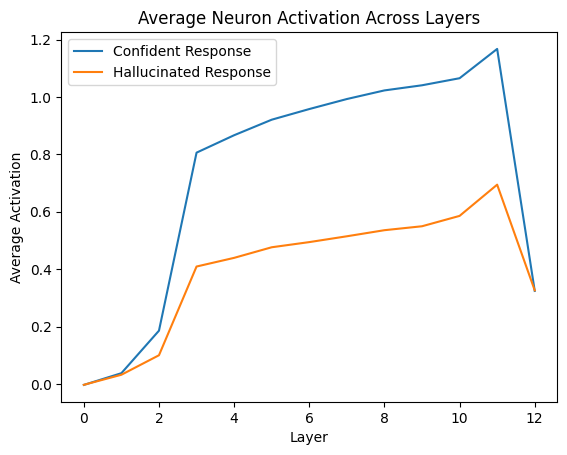

In [7]:
confident_prompt = "Who was Albert Einstein?"
hallucination_prompt = "What were the childhood hobbies of Cleopatra?"

plot_average_activations(confident_prompt, hallucination_prompt)

### Example 2: 2 Hallucination Prompts

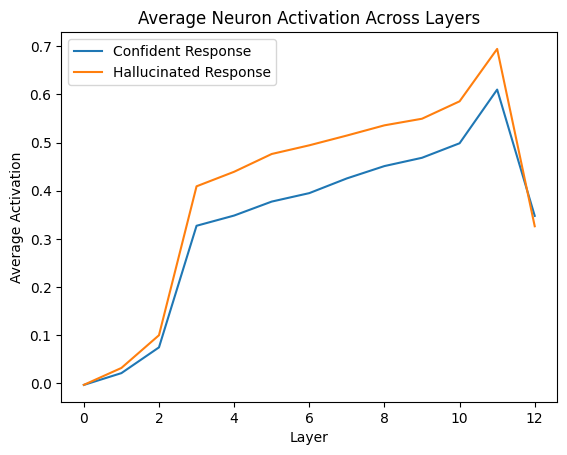

In [8]:
confident_prompt = "Who made the first boomerang according to Australian folklore?"
hallucination_prompt = "What were the childhood hobbies of Cleopatra?"

plot_average_activations(confident_prompt, hallucination_prompt)

### Example 3: 2 Confident Prompts


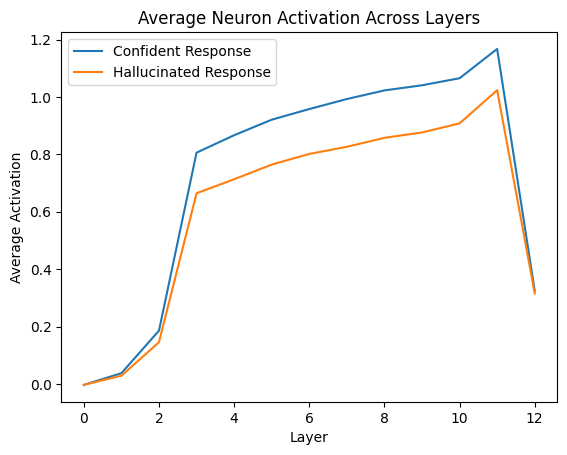

In [9]:
confident_prompt = "Who was Albert Einstein?"
hallucination_prompt = "Why is the sky blue?"

plot_average_activations(confident_prompt, hallucination_prompt)

### **Summary & Insights:**

- There is a clear difference between the average activations against a confident prompt and a hallucinated prompt
- There's almost a 2x-3x drop off between the highest activations against the confident prompt (~ 1.3) and hallucinated prompt (~ 0.6)
- This demonstrates that yes, prompts for which LLMs have more established knowledge bases have higher average activations than the prompts that cause LLMs to hallucinate
- For the particular case of GPT, regardless of confidence, there seems to be a huge spike around layer 3 and another spike at layer 11, with that being the peak activation overall
- Regardless of prompt, their activation ends at the same value at the last layer (layer 12)


## Part 2: Effect of minute perturbations in prompt to LLMs

This section of the notebook examines effect of minute perturbations in the same prompt and the changes in which part of the prompt is paid more attention to through SHAP values.

**Process:**
- Initialise the GPT2 model
- Tokenize the prompt
- Pass the model and tokenizer to the SHAP explainer
- Plot SHAP values for the prompt

In [10]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("gpt2")

# set model decoder to true
model.config.is_decoder = True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.7,
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Example 1: Neutral punctuation (.)

In [11]:
prompt = "Tell me something interesting about space."
viz_shap(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/42 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.48s/it]               


### Example 2: Excited punctuation (!)

In [12]:
prompt = "Tell me something interesting about space!"
viz_shap(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/42 [00:00<?, ?it/s]

### Example 3: Aggressive prompt ("now")

In [13]:
prompt = "Give me a summary of artificial intelligence now"
viz_shap(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/56 [00:00<?, ?it/s]

### Example 4: Polite prompt (can, please)

In [14]:
prompt = "Could you please provide a summary of artificial intelligence"
viz_shap(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/72 [00:00<?, ?it/s]

### **Summary & Insights:**

- Excited punctuation like exclamations seem to have more significance as opposed to just neutral punctuations like periods.
- Aggressive language seems to have more significance as opposed to using more pleasing language